In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from random import randint
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC

In [2]:
df_whole = pd.read_csv('data.csv', encoding='gbk')
df_whole.drop(columns=[df_whole.columns[0]], inplace=True)

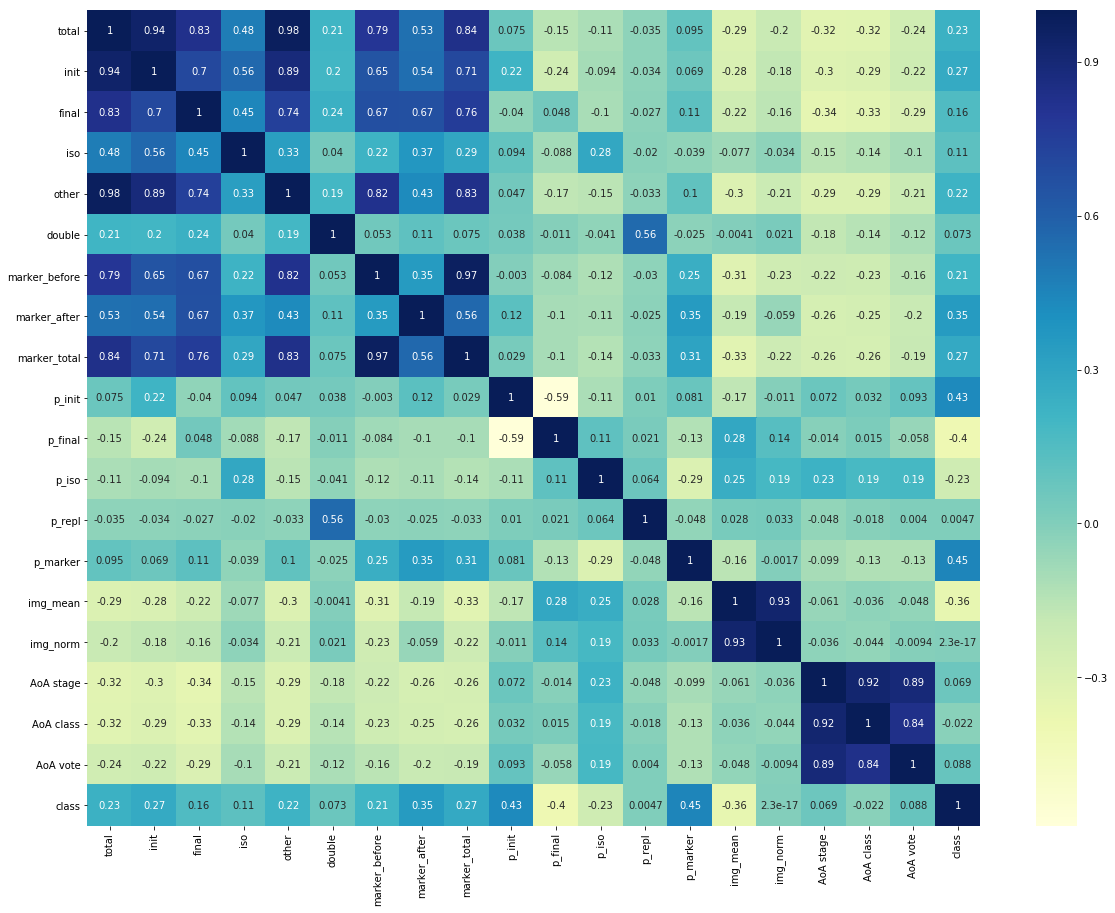

In [4]:
corr = df_whole.corr()
f, ax = plt.subplots(figsize = (20, 15))
sns.heatmap(corr, annot=True, cmap="YlGnBu")

In [5]:
def random_evaluate(X_data, y_data, seeds, n_class):
    acc_list, p_list, r_list, f1_list = [], [], [], []
    for seed in seeds:
        X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=seed)
        
        y_pred = []
        for i in range(len(y_test)):
            y_pred.append(randint(0, n_class-1))

        acc_list.append(accuracy_score(y_test, y_pred))
        p, r, f1, s = precision_recall_fscore_support(y_test, y_pred)
        p_list.append(np.average(p, weights=s))
        r_list.append(np.average(r, weights=s))
        f1_list.append(np.average(f1, weights=s))
    
    return acc_list, p_list, r_list, f1_list

In [6]:
def model_evaluate(X_data, y_data, model, seeds, select_feature = False):
    # note that for multiclass problem, there are n_group weights
    acc_list, p_list, r_list, f1_list = [], [], [], []
    weights, features = [], []
    
    for seed in seeds:
        X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=seed)
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc_list.append(accuracy_score(y_test, y_pred))
        p, r, f1, s = precision_recall_fscore_support(y_test, y_pred)
        p_list.append(np.average(p, weights=s))
        r_list.append(np.average(r, weights=s))
        f1_list.append(np.average(f1, weights=s))
        
        if select_feature:
            selector = SelectFromModel(model, prefit=True, threshold='median')
            if hasattr(selector.estimator, 'feature_importances_'):    # for decision tree    
                weights.append(selector.estimator.feature_importances_.squeeze().tolist())
            elif hasattr(selector.estimator, 'coef_'):                 # for logistic regression and SVC
                weights.append(selector.estimator.coef_.squeeze().tolist())
            features.extend(selector.get_support(indices=True).tolist())
    
    # print(np.array(weights).shape)
    mean_weights = np.array(weights).mean(axis=0).tolist()
    
    return acc_list, p_list, r_list, f1_list, mean_weights, features

In [7]:
# lr = DecisionTreeClassifier()
# model_evaluate(X_data, y_data, lr, [1,2,3,4], True)

In [8]:
def multi_evaluate(X_data, y_data, model_list, times, include_random = False, n_class=2, select_feature=False):
    acc_means, acc_stds = [], []
    f1_means, f1_stds = [], []
    seeds = []
    model_weights, model_features = [], []
    
    for i in range(times):
        seeds.append(randint(0, 999999))
    for model in model_list:
        acc_list, p_list, r_list, f1_list, weights, features = model_evaluate(X_data, y_data, model, seeds, select_feature)
        acc_means.append(np.array(acc_list).mean())
        acc_stds.append(np.array(acc_list).std())
        f1_means.append(np.array(f1_list).mean())
        f1_stds.append(np.array(f1_list).std())
        
        model_weights.append(weights)
        model_features.extend(features)
        
    if include_random:
        acc_list, p_list, r_list, f1_list = random_evaluate(X_data, y_data, seeds, n_class)
        acc_means.append(np.array(acc_list).mean())
        acc_stds.append(np.array(acc_list).std())
        f1_means.append(np.array(f1_list).mean())
        f1_stds.append(np.array(f1_list).std())
        
    features_count = (np.bincount(model_features)/(times*len(model_list))).tolist()
        
    return acc_means, acc_stds, f1_means, f1_stds, model_weights, features_count

In [9]:
def draw_bar(res, model_names):
    acc_means, acc_stds, f1_means, f1_stds = res
    N = len(model_names)
    ind = np.arange(N)  # the x locations for the groups
    width = 0.30       # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(ind, acc_means, width, color='steelblue', yerr=acc_stds, alpha=0.7)
    rects2 = ax.bar(ind + width, f1_means, width, color='orange', yerr=f1_stds, alpha=0.7)

    # add some text for labels, title and axes ticks
    ax.set_ylabel('Performances')
    ax.set_title('Accuracy and F1 Score by Model')
    ax.set_xticks(ind + width/2)
    ax.set_xticklabels(model_names)
    ax.legend((rects1[0], rects2[0]), ('Acc', 'F1'))
    plt.show()

### Task 1: Noun-Verb Categorizaion

In [10]:
df_processed = df_whole.drop(columns=['pinyin', 'word', 'conflict_d', 'AoA stage', 'AoA class', 'AoA vote', 'img_norm'])
# for noun-verb classification, mean imageability is used, as the inter-class differences should be maintained.
df_processed.head()

,total,init,final,iso,other,double,marker_before,marker_after,marker_total,p_init,p_final,p_iso,p_repl,p_marker,img_mean,class
0,1371,97,540,52,682,110,159,0,159,0.070751,0.393873,0.037929,0.080233,0.115974,5.30,0
1,1295,457,119,191,528,0,16,0,16,0.352896,0.091892,0.147490,0.000000,0.012355,5.75,0
2,1199,205,306,12,676,15,45,0,45,0.170976,0.255213,0.010008,0.012510,0.037531,4.95,0
3,1169,331,138,74,626,0,49,0,49,0.283148,0.118050,0.063302,0.000000,0.041916,4.25,0
4,601,165,68,103,265,0,13,0,13,0.274542,0.113145,0.171381,0.000000,0.021631,5.60,0


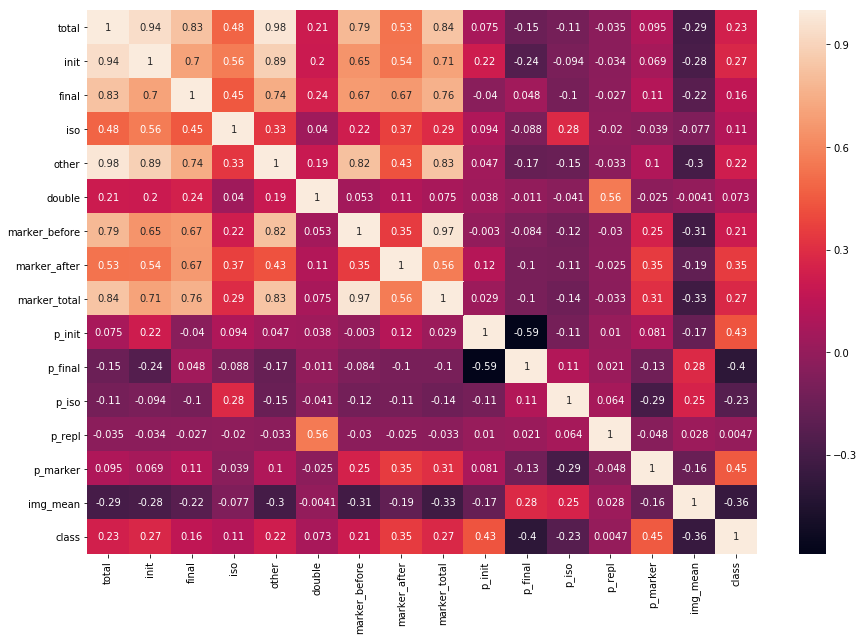

In [11]:
corr = df_processed.corr()
f, ax = plt.subplots(figsize = (15, 10))
sns.heatmap(corr, annot=True)

In [12]:
y_data = df_processed['class'].values
X_data = df_processed.drop(columns=['class']).values
print(X_data.shape, y_data.shape)

(347, 15) (347,)


In [13]:
model_names = ['LR', 'DT', 'SVM', 'Random']
lr = LogisticRegression()
dt = DecisionTreeClassifier()
svc = LinearSVC()
# svc = SVC()
# svc with rbf kernel results with 0.65p

res = multi_evaluate(X_data, y_data, [lr, dt, svc], 100, include_random=True, n_class=2, select_feature=True)
print(res)

([0.9139047619047621, 0.9467619047619047, 0.872095238095238, 0.5041904761904761], [0.02336421668524739, 0.019890630663923572, 0.0570674899807098, 0.04551185338113513], [0.9130763763077767, 0.9467473185548754, 0.8706017286865861, 0.5047280604580426], [0.023640946555698424, 0.019906080088158785, 0.05991202551550832, 0.04536356223978342], [[-0.009755283299895313, 0.015298446372721174, -0.061656931701669214, 0.01409696979898509, 0.02250623223008325, 0.000768456528880099, -1.1691511852123813, 2.290856684785254, 1.1217054995728737, 1.08535119846717, -0.09565007187470372, 0.019769059490778288, 0.17198177319237387, -0.5847008084661983, -0.4788258001792971], [0.020934561447876084, 0.05018479632823297, 0.004450143771496873, 0.0030154706711047613, 0.011191131336042704, 0.003073595137154014, 0.02710044346974737, 0.7459482479183294, 0.0288078923414387, 0.009631100474999613, 0.007492167616929319, 0.003410435676546398, 0.001901400986760164, 0.02545135138543688, 0.05740726143790442], [0.00649205294591

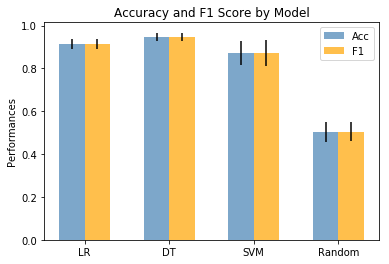

In [14]:
draw_bar(res[0:-2], model_names)

In [15]:
task1_importance = res[-1]
print(task1_importance)

[0.2966666666666667, 0.3433333333333333, 0.2966666666666667, 0.23, 0.28, 0.22666666666666666, 0.9033333333333333, 1.0, 0.91, 0.94, 0.7066666666666667, 0.5933333333333334, 0.73, 0.8566666666666667, 0.9966666666666667]


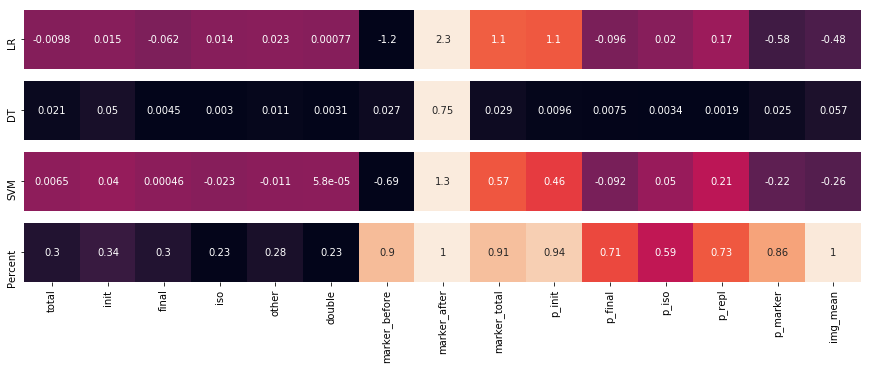

In [16]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(15,5),nrows=4)
sns.heatmap([res[-2][0]], annot=True, ax=ax1, yticklabels=['LR'], xticklabels=False, cbar=False)
sns.heatmap([res[-2][1]], annot=True, ax=ax2, yticklabels=['DT'], xticklabels=False, cbar=False)
sns.heatmap([res[-2][2]], annot=True, ax=ax3, yticklabels=['SVM'], xticklabels=False, cbar=False)
sns.heatmap([res[-1]], annot=True, ax=ax4, yticklabels=['Percent'], xticklabels=df_processed.columns[:-1], cbar=False)

### Task 2: AoA Stage Prediction

#### Using AoA mean as class label

In [15]:
df_processed_mean = df_whole.drop(columns=['pinyin', 'word', 'conflict_d', 'AoA stage', 'AoA vote', 'img_mean', 'class'])
df_processed_mean.head()

,total,init,final,iso,other,double,marker_before,marker_after,marker_total,p_init,p_final,p_iso,p_repl,p_marker,img_norm,AoA class
0,1371,97,540,52,682,110,159,0,159,0.070751,0.393873,0.037929,0.080233,0.115974,-0.106328,1
1,1295,457,119,191,528,0,16,0,16,0.352896,0.091892,0.147490,0.000000,0.012355,0.211130,1
2,1199,205,306,12,676,15,45,0,45,0.170976,0.255213,0.010008,0.012510,0.037531,-0.368324,2
3,1169,331,138,74,626,0,49,0,49,0.283148,0.118050,0.063302,0.000000,0.041916,-0.966122,1
4,601,165,68,103,265,0,13,0,13,0.274542,0.113145,0.171381,0.000000,0.021631,0.114581,1


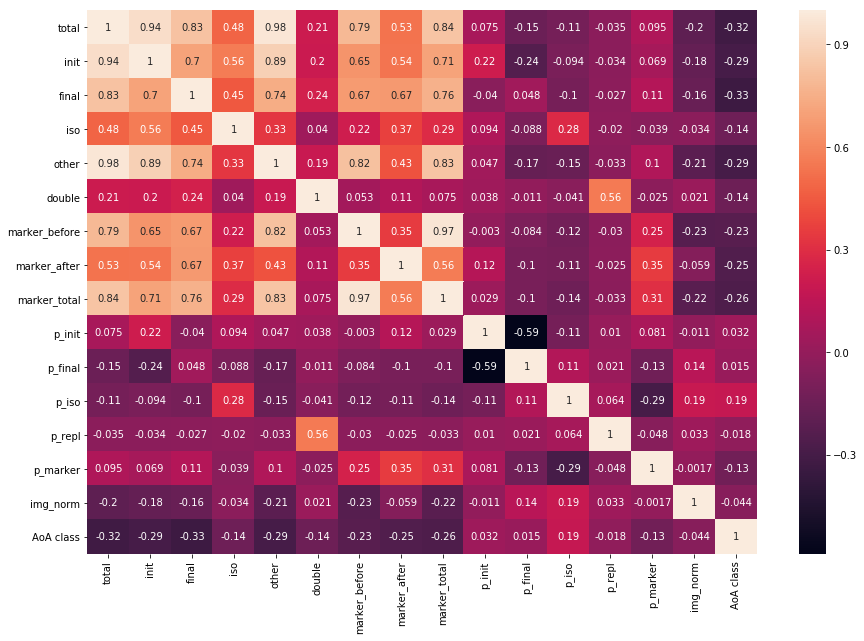

In [16]:
corr = df_processed_mean.corr()
f, ax = plt.subplots(figsize = (15, 10))
sns.heatmap(corr, annot=True)

In [17]:
y_data = df_processed_mean['AoA class'].values
X_data = df_processed_mean.drop(columns=['AoA class']).values
print(X_data.shape, y_data.shape)

(347, 15) (347,)


In [54]:
import warnings 
warnings.filterwarnings('ignore')

model_names = ['LR', 'DT', 'SVM', 'Random']
lr = LogisticRegression(multi_class='ovr')
dt = DecisionTreeClassifier(max_depth=3)
# svc = LinearSVC()
svc = SVC(kernel='rbf')
# using SVC with linear kernel reach performance of 0.45 with moderate variation
res = multi_evaluate(X_data, y_data, [lr, dt, svc], 100, include_random=True, n_class=3, select_feature=False)
# res = multi_evaluate(X_data, y_data, [lr, dt, svc], 100, True, 3, True)
print(res)

([0.4674285714285714, 0.47590476190476183, 0.4012380952380953, 0.2216190476190476], [0.047651036874266896, 0.04061779152861626, 0.043905794843752434, 0.03770887407061459], [0.45889708984048583, 0.46014310575447936, 0.33838963942357, 0.22115115311461753], [0.052120406993133986, 0.046806161235570604, 0.046802870172354884, 0.03692042613858318], [nan, nan, nan], [])


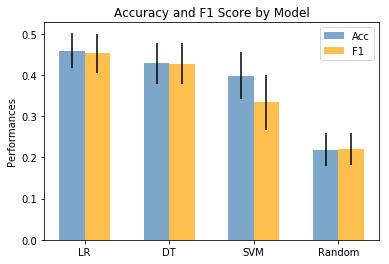

In [22]:
draw_bar(res[:-2], model_names)

In [50]:
# print(len(res[-2][0])) # logistic regression
# print(len(res[-2][1])) # decision tree
# print(len(res[-2][2])) # support vector machine
# # this is because for multiclass problem, there are several groups of weights for each class

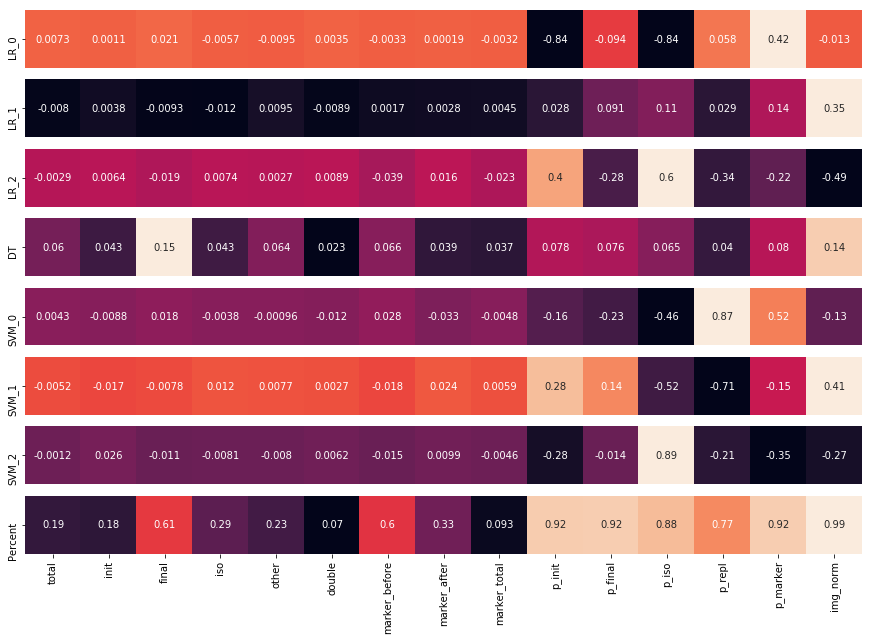

In [61]:
f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(figsize=(15,10),nrows=8)
sns.heatmap([res[-2][0][0]], annot=True, ax=ax1, yticklabels=['LR_0'], xticklabels=False, cbar=False)
sns.heatmap([res[-2][0][1]], annot=True, ax=ax2, yticklabels=['LR_1'], xticklabels=False, cbar=False)
sns.heatmap([res[-2][0][2]], annot=True, ax=ax3, yticklabels=['LR_2'], xticklabels=False, cbar=False)
sns.heatmap([res[-2][1]], annot=True, ax=ax4, yticklabels=['DT'], xticklabels=False, cbar=False)
sns.heatmap([res[-2][2][0]], annot=True, ax=ax5, yticklabels=['SVM_0'], xticklabels=False, cbar=False)
sns.heatmap([res[-2][2][1]], annot=True, ax=ax6, yticklabels=['SVM_1'], xticklabels=False, cbar=False)
sns.heatmap([res[-2][2][2]], annot=True, ax=ax7, yticklabels=['SVM_2'], xticklabels=False, cbar=False)
sns.heatmap([res[-1]], annot=True, ax=ax8, yticklabels=['Percent'], xticklabels=df_processed_mean.columns[:-1], cbar=False)

#### Using AoA vote as class label

In [17]:
df_processed_vote = df_whole.drop(columns=['pinyin', 'word', 'conflict_d', 'AoA stage', 'class', 'AoA class', 'img_mean'])
df_processed_vote.head()

,total,init,final,iso,other,double,marker_before,marker_after,marker_total,p_init,p_final,p_iso,p_repl,p_marker,img_norm,AoA vote
0,1371,97,540,52,682,110,159,0,159,0.070751,0.393873,0.037929,0.080233,0.115974,-0.106328,1
1,1295,457,119,191,528,0,16,0,16,0.352896,0.091892,0.147490,0.000000,0.012355,0.211130,1
2,1199,205,306,12,676,15,45,0,45,0.170976,0.255213,0.010008,0.012510,0.037531,-0.368324,1
3,1169,331,138,74,626,0,49,0,49,0.283148,0.118050,0.063302,0.000000,0.041916,-0.966122,1
4,601,165,68,103,265,0,13,0,13,0.274542,0.113145,0.171381,0.000000,0.021631,0.114581,1


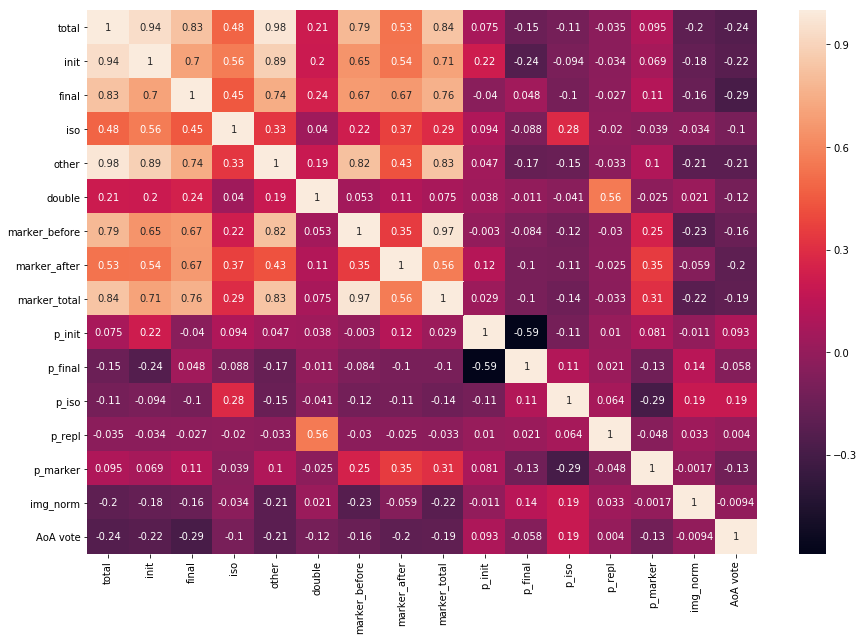

In [18]:
corr = df_processed_vote.corr()
f, ax = plt.subplots(figsize = (15, 10))
sns.heatmap(corr, annot=True)

In [19]:
y_data = df_processed_vote['AoA vote'].values
X_data = df_processed_vote.drop(columns=['AoA vote']).values
print(X_data.shape, y_data.shape)

(347, 15) (347,)


In [20]:
import warnings 
warnings.filterwarnings('ignore')

model_names = ['LR', 'DT', 'SVM', 'Random']
lr = LogisticRegression()
dt = DecisionTreeClassifier()
svc = LinearSVC()
res = multi_evaluate(X_data, y_data, [lr, dt, svc], 100, True, 3, True)
print(res)

([0.5219047619047619, 0.4341904761904761, 0.42961904761904757, 0.25809523809523804], [0.03821410028140739, 0.042122701663887284, 0.08088955545313557, 0.03850965070315377], [0.48676790020679883, 0.43462635366125085, 0.36947706873122393, 0.2822872334600341], [0.04259102361929866, 0.04383840869909488, 0.10166063700611601, 0.04084025754527365], [[[0.007253586726150807, 0.0002731298326357641, 0.02059914957821199, -0.004178299481740499, -0.009440393202613046, 0.005839176271584683, -0.003110202922927525, 0.00029120088171084884, -0.0028190020411775745, -0.8686188914117651, -0.08365961257498503, -0.8853599835134651, -0.07064764165847422, 0.4525184852109011, -0.00953499462235805], [-0.007887228018626305, 0.0038584328478917605, -0.00863170142202993, -0.012745923718509735, 0.009631964274138628, -0.010267561732121889, 0.0015020156144273903, 0.002539357055704655, 0.0040413726701102656, 0.09435068679075903, 0.08690254779533246, 0.1313327826901476, 0.09234913984256668, 0.13010310476362155, 0.334062434

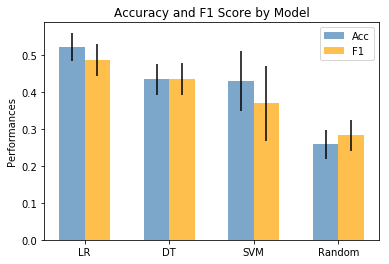

In [21]:
draw_bar(res[:-2], model_names)

In [22]:
task2_importance = res[-1]
print(task2_importance)

[0.17333333333333334, 0.21666666666666667, 0.5933333333333334, 0.29333333333333333, 0.2733333333333333, 0.04666666666666667, 0.6433333333333333, 0.32, 0.09333333333333334, 0.91, 0.9266666666666666, 0.83, 0.75, 0.93, 1.0]


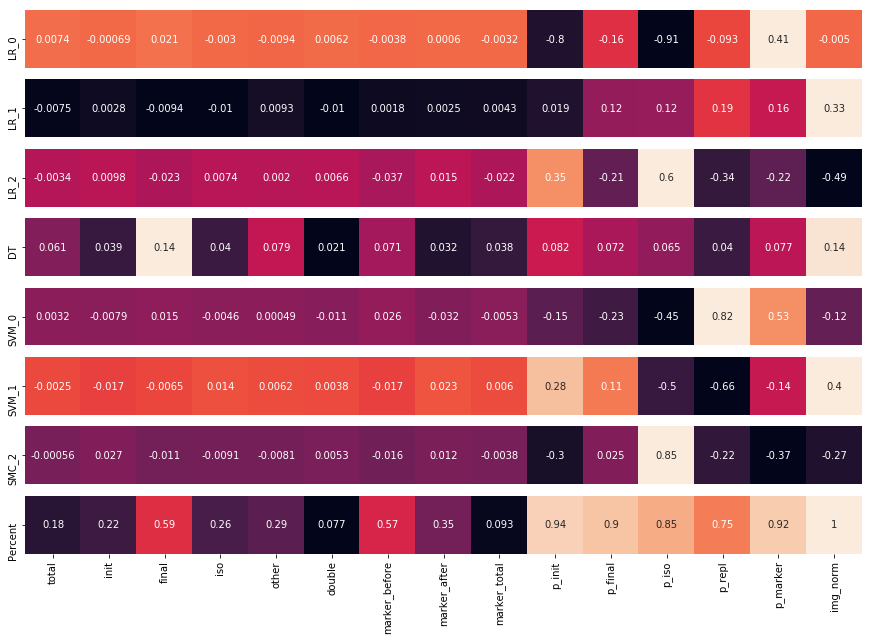

In [58]:
f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(figsize=(15,10),nrows=8)
sns.heatmap([res[-2][0][0]], annot=True, ax=ax1, yticklabels=['LR_0'], xticklabels=False, cbar=False)
sns.heatmap([res[-2][0][1]], annot=True, ax=ax2, yticklabels=['LR_1'], xticklabels=False, cbar=False)
sns.heatmap([res[-2][0][2]], annot=True, ax=ax3, yticklabels=['LR_2'], xticklabels=False, cbar=False)
sns.heatmap([res[-2][1]], annot=True, ax=ax4, yticklabels=['DT'], xticklabels=False, cbar=False)
sns.heatmap([res[-2][2][0]], annot=True, ax=ax5, yticklabels=['SVM_0'], xticklabels=False, cbar=False)
sns.heatmap([res[-2][2][1]], annot=True, ax=ax6, yticklabels=['SVM_1'], xticklabels=False, cbar=False)
sns.heatmap([res[-2][2][2]], annot=True, ax=ax7, yticklabels=['SMC_2'], xticklabels=False, cbar=False)
sns.heatmap([res[-1]], annot=True, ax=ax8, yticklabels=['Percent'], xticklabels=df_processed_vote.columns[:-1], cbar=False)

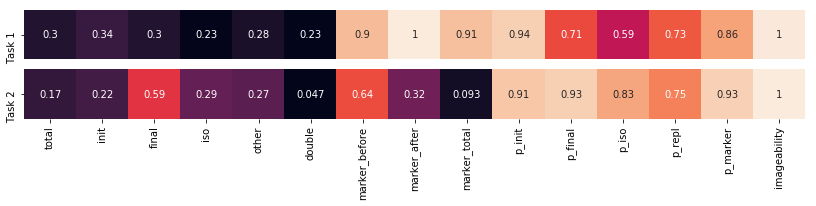

In [34]:
f, (ax1, ax2) = plt.subplots(figsize=(14,2),nrows=2)
sns.heatmap([task1_importance], annot=True, ax=ax1, yticklabels=['Task 1'], xticklabels=False, cbar=False)
sns.heatmap([task2_importance], annot=True, ax=ax2, yticklabels=['Task 2'], xticklabels=feature_names, cbar=False)

In [33]:
feature_names = list(df_processed.columns[:-1].values)
feature_names[-1] = 'imageability'